In [1]:
import pyscheduling.FS.FmCmax as fs
import os
import pyscheduling.Problem as pb
import pyscheduling.FS.FlowShop as FlowShop
import time
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import numpy as np
import pulp as lp 

In [2]:
rand_instance = fs.FmCmax_Instance.generate_random(20, 5)

In [3]:
def get_data(filename, i):
    with open(filename, 'r') as f:
        data = f.read()
    lines = data.split('\n')
    data = lines[i*8:(i+1)*8][3:]
    data = [x.split() for x in data]
    data = [[int(y) for y in x] for x in data]
    data = list(map(list, zip(*data)))

    job_number = int(lines[i*8:(i+1)*8][1].split()[0])
    machine_num = int(lines[i*8:(i+1)*8][1].split()[1])
    return fs.FmCmax_Instance("test", job_number, machine_num, data)

In [4]:
instance = get_data("data.txt", 0)
instance.P

[[54, 79, 16, 66, 58],
 [83, 3, 89, 58, 56],
 [15, 11, 49, 31, 20],
 [71, 99, 15, 68, 85],
 [77, 56, 89, 78, 53],
 [36, 70, 45, 91, 35],
 [53, 99, 60, 13, 53],
 [38, 60, 23, 59, 41],
 [27, 5, 57, 49, 69],
 [87, 56, 64, 85, 13],
 [76, 3, 7, 85, 86],
 [91, 61, 1, 9, 72],
 [14, 73, 63, 39, 8],
 [29, 75, 41, 41, 49],
 [12, 47, 63, 56, 47],
 [77, 14, 47, 40, 87],
 [32, 21, 26, 54, 58],
 [87, 86, 75, 77, 18],
 [68, 5, 77, 51, 68],
 [94, 77, 40, 31, 28]]

In [5]:
solution = fs.Heuristics.slope(instance)
print(solution)


Search stopped with status : FEASIBLE
 Solution is : 
 Objective : 1409
Jobs sequence : 8	16	10	2	14	15	18	7	13	5	0	1	12	3	4	11	6	9	19	17
Machine_ID | Job_schedule (job_id , start_time , completion_time) | Completion_time
(8, 0, 27) : (16, 27, 59) : (10, 59, 135) : (2, 135, 150) : (14, 150, 162) : (15, 162, 239) : (18, 239, 307) : (7, 307, 345) : (13, 345, 374) : (5, 374, 410) : (0, 410, 464) : (1, 464, 547) : (12, 547, 561) : (3, 561, 632) : (4, 632, 709) : (11, 709, 800) : (6, 800, 853) : (9, 853, 940) : (19, 940, 1034) : (17, 1034, 1121) | 1121
(8, 27, 32) : (16, 59, 80) : (10, 135, 138) : (2, 150, 161) : (14, 162, 209) : (15, 239, 253) : (18, 307, 312) : (7, 345, 405) : (13, 405, 480) : (5, 480, 550) : (0, 550, 629) : (1, 629, 632) : (12, 632, 705) : (3, 705, 804) : (4, 804, 860) : (11, 860, 921) : (6, 921, 1020) : (9, 1020, 1076) : (19, 1076, 1153) : (17, 1153, 1239) | 1239
(8, 32, 89) : (16, 89, 115) : (10, 138, 145) : (2, 161, 210) : (14, 210, 273) : (15, 273, 320) : (18, 320, 3

In [6]:
class BB(pb.Branch_Bound):

    def branch(self, node: pb.Branch_Bound.Node):
        """Règle de branchement

        Args:
            node (pb.Branch_Bound.Node): node to branch from
        """

        if node.partial_solution is None:
            node.partial_solution = FlowShop.FlowShopSolution(self.instance)
            node.sub_nodes = []
            for i in range(self.instance.n):
                copy = node.partial_solution.copy()
                copy.job_schedule.append(pb.Job(i, 0, 0))
                node.sub_nodes.append(
                    pb.Branch_Bound.Node(partial_solution=copy))
        else:
            node.sub_nodes = []
            if_solution = True if len(
                node.partial_solution.job_schedule) == self.instance.n-1 else False
            for i in range(self.instance.n):
                job_schedule = [
                    job.id for job in node.partial_solution.job_schedule]
                if i not in job_schedule:
                    copy = node.partial_solution.copy()
                    copy.job_schedule.append(pb.Job(i, 0, 0))
                    node.sub_nodes.append(pb.Branch_Bound.Node(
                        if_solution=if_solution, partial_solution=copy))
                    

    def palmer_bound(self):
        """Palmer's bound for the flowshop problem
        Args:
            process_times (list): list of lists of processing times
        Returns:
            int: bound
        """
        P= self.instance.P
        n = self.instance.n
        m = self.instance.m
        machine_sum = [0] * m
        for i in range(n):
            for j in range(m):
                machine_sum[j] += P[i][j]
                if j > 0:
                    machine_sum[j] = max(machine_sum[j], machine_sum[j-1])
        return machine_sum[-1]


    def linear_programming(self, node: pb.Branch_Bound.Node):
        """Solve the linear programming relaxation of the flow shop scheduling problem
        for the partial schedule in the given node.
        """
        model = lp.LpProblem("FlowShopLP", lp.LpMinimize)
        
        # Variables
        n = len(node.partial_solution.job_schedule)
        start_times = lp.LpVariable.dicts("start_time", [(i, j) for i in range(n) for j in range(self.instance.m)],
                                          lowBound=0, cat='Continuous')
        end_times = lp.LpVariable.dicts("end_time", [(i, j) for i in range(n) for j in range(self.instance.m)],
                                        lowBound=0, cat='Continuous')
        lateness = lp.LpVariable.dicts("lateness", [i for i in range(n)], lowBound=0, cat='Continuous')
        
        # Objective function
        model += lp.lpSum(lateness)
        
        # Constraints
        for i in range(n):
            if i == 0:
                model += start_times[(i, 0)] == 0
            else:
                model += start_times[(i, 0)] >= end_times[(i-1, 0)]
            model += start_times[(i, 1)] >= end_times[(i, 0)]
            model += start_times[(i, 2)] >= end_times[(i, 1)]
            model += end_times[(i, 0)] == start_times[(i, 0)] + self.instance.P[node.partial_solution.job_schedule[i].id][0]
            model += end_times[(i, 1)] == start_times[(i, 1)] + self.instance.P[node.partial_solution.job_schedule[i].id][1]
            model += end_times[(i, 2)] == start_times[(i, 2)] + self.instance.P[node.partial_solution.job_schedule[i].id][2]
            model += lateness[i] >= end_times[(i, 2)] - self.instance.P[node.partial_solution.job_schedule[i].id]
        
        # Solve the model
        model.solve()
        
        # C     heck if the problem is feasible
        if lp.LpStatus[model.status] != "Optimal":
            return None
        
        # Update the lower bound
        return int(lp.value(model.objective))


    def johnson_algorithm(self, node: pb.Branch_Bound.Node):
        if node.partial_solution is None:
            # Compute initial lower bound using Johnson's Rule
            node.partial_solution = FlowShop.FlowShopSolution(self.instance)
            node.partial_solution.schedule = self.johnsons_rule()
            return node.partial_solution.compute_objective()
        else:
            # Compute lower bound using partial schedule and minimum completion time
            c = [job.end_time for job in node.partial_solution.job_schedule]
            t = [0] * self.instance.m
            for i in range(len(c)):
                t[i % self.instance.m] = c[i]
            return max(t)

    def johnsons_rule(self):
        n = self.instance.n
        m = self.instance.m
        P = self.instance.P

        # Step 1: Sort jobs by their shortest processing time
        s = sorted(range(n), key=lambda j: min(P[j]))

        # Step 2: Determine the processing order for each job on the two machines
        a = [0] * n
        b = [0] * n
        k = 0
        j = n - 1
        while s:
            if min(P[s[0]][0], P[s[0]][1]) <= min(P[s[j]][0], P[s[j]][1]):
                j -= 1
                k += 1
            else:
                i = s.pop(0)
                if P[i][0] < P[i][1]:
                    a[k] = i
                    k += 1
                else:
                    b[j] = i
                    j -= 1

        # Step 3: Combine the processing orders to create a feasible schedule
        c = [0] * (n * m)
        t = [0] * m
        for i in range(n):
            c[i * m + a[i]] = t[0]
            t[0] += P[a[i]][0]
            for j in range(1, m):
                c[i * m + a[i] + j * n] = t[j]
                t[j] = max(t[j], t[j-1]) + P[a[i]][j]
        for i in range(n):
            c[i * m + b[i]] = t[0]
            t[0] += P[b[i]][0]
            for j in range(1, m):
                c[i * m + b[i] + j * n] = t[j]
                t[j] = max(t[j], t[j-1]) + P[b[i]][j]

        return c

    def bound(self, node: pb.Branch_Bound.Node):
        """Bounding method using Johnson's Rule

        Args:
            node (pb.Branch_Bound.Node): node to bound
        """
        node.lower_bound = self.johnson_algorithm(node)

    def objective(self, node: pb.Branch_Bound.Node):
        """Fonction objectif

        Args:
            node (pb.Branch_Bound.Node): node to be evaluated as a solution

        Returns:
            int: maximum lateness
        """
        node.lower_bound = node.partial_solution.compute_objective()
        return node.lower_bound

    def solution_format(self, partial_solution: FlowShop.FlowShopSolution):
        partial_solution.compute_objective()
        return partial_solution

    def draw_gantt_chart(self, height=0.5, spacing=0.1):

        # get data
        machines = self.best_solution.machines

        # get colors
        colors = plt.cm.rainbow(np.linspace(0, 1, len(machines)))

        # draw gantt chart
        _, ax = plt.subplots()

        for i, machine in enumerate(machines):
            # change bar height
            for job in machine.oper_schedule:
                y = i*(height+spacing)
                ax.broken_barh(
                    [(job.start_time, job.end_time-job.start_time)], (y, height), facecolors=colors[i])

        # draw x axis
        ax.set_xlabel('time (s)')
        ax.set_xlim(0, self.best_solution.compute_objective())

        ticks = [i*(height+spacing) + height/2 for i in range(len(machines))]
        ax.set_yticks(ticks)

        ax.set_yticklabels(['machine {}'.format(i)
                           for i in range(len(machines))])

        # show gantt chart
        plt.show()
        
    def new_bound(self,node:pb.Branch_Bound):
        P=self.instance.P
        n=self.instance.n
        partial_sol=[int(job.id) for job in node.partial_solution.job_schedule]
        remaining_job = [i for i in range(n) if i not in partial_sol]
        return P[partial_sol,1:].max() + P[remaining_job,:].sum(axis=0).max()
     
    def solve(self, root: pb.Branch_Bound.Node = None, time_limit=60):
        """recursive function to perform Branch&Bound on the instance attribute
        Args:
            root (Node, optional): starting node. Defaults to None.
        """

        if root is None:
            root = self.Node()
            self.root = root
            self.start_time = time.perf_counter()
            self.runtime = 0

        if self.runtime > time_limit:
            return

        self.branch(root)
        if root.sub_nodes[0].if_solution is False:
            for node in root.sub_nodes:
                self.bound(node)
            sorted_sub_nodes = root.sub_nodes
            sorted_sub_nodes.sort(reverse=self.instance.get_objective(
            ).value > 0, key=lambda node: node.lower_bound)
            for node in sorted_sub_nodes:
                if self.best_solution is not None:
                    if self.instance.get_objective().value > 0 and node.lower_bound < self.objective_value:
                        node = None
                    elif self.instance.get_objective().value < 0 and node.lower_bound > self.objective_value:
                        node = None
                if node is not None:
                    self.solve(node, time_limit)
        else:
            for node in root.sub_nodes:
                node.lower_bound = self.objective(node)
                solution = self.solution_format(node.partial_solution)
                self.all_solution.append(solution)
                if self.best_solution is None or (self.instance.get_objective().value > 0 and self.objective_value < node.lower_bound):
                    self.objective_value = node.lower_bound
                    self.best_solution = solution
                elif self.best_solution is None or (self.instance.get_objective().value < 0 and node.lower_bound < self.objective_value):
                    self.objective_value = node.lower_bound
                    self.best_solution = solution
        self.runtime = time.perf_counter() - self.start_time


In [7]:
algo = BB(instance)

In [8]:
algo.solve(time_limit=60)

AttributeError: 'Machine' object has no attribute 'wiCi_index'

In [9]:
print(algo.best_solution)

None


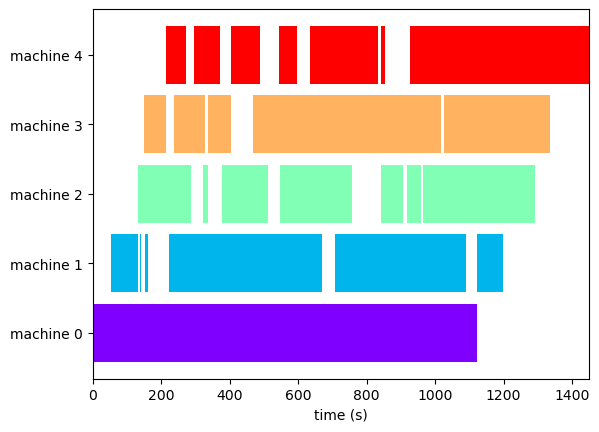

In [36]:
algo.draw_gantt_chart()